In [1]:
from lipunova import ShakuraSunyaevDisk, AdvectiveDiskWithOutflows, AdvectiveDiskWithoutOutflows, DiskWithOutflows
from lipunova import isco_radius, eddington_accretion_rate, keplerian_angular_w, find_rsph, scale_height, mass_transfer_inner_radius
import numpy as np
import os
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
from astropy.constants import M_sun, sigma_T, m_p

In [2]:
outdir = "lipunova/%s" % "testing_disks"

if not os.path.isdir(outdir):
    os.mkdir(outdir)
alpha = 0.1
M = 10 * M_sun.to(u.g).value
k_T = (sigma_T / m_p).decompose(bases=u.cgs.bases).value
c = c.decompose(bases=u.cgs.bases).value

## Shakura & Sunyaev disk (Conservative and non-advective disk)

Disk ShakuraSunyaevDisk with M = 10.0 M_sun, dot(m) = 0.5 and alpha = 0.1 and spin = 0.0
Is energy conserved in ShakuraSunyaevDisk disks?
True
According to SS73 the maximum of Qr^2 occurs at 2.25R_0:
True


/home/andresgur/scripts/pythonscripts/formulas/lipunova.py:190: RuntimeWarning: invalid value encountered in divide
  return -Wrphi / (2 * self.alpha * w**2 * H**3)


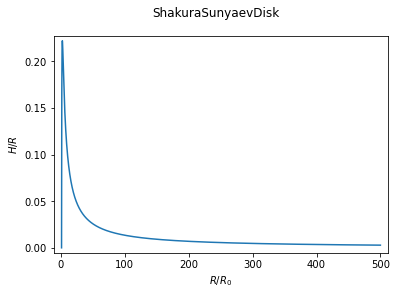

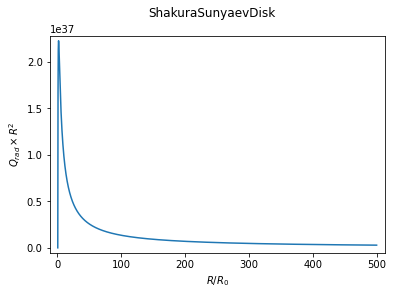

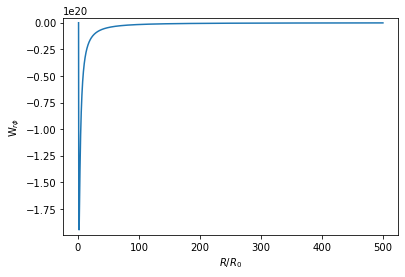

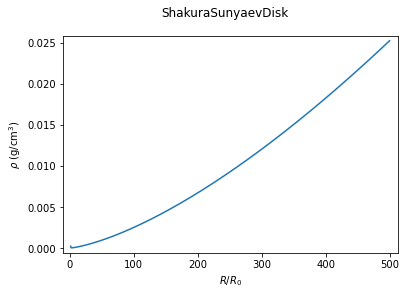

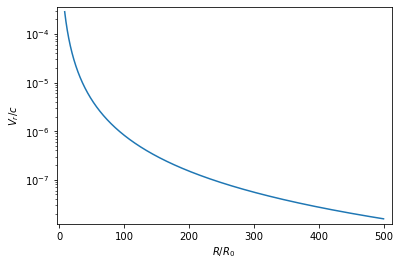

In [3]:
mdot = 0.5
       
disk = ShakuraSunyaevDisk(M, mdot, alpha, Rmin=1, Rmax=500, spin=0)
Mdot_0 = disk.R0
R = np.arange(disk.Rmin, disk.Rmax, 0.05) * disk.R0
w = keplerian_angular_w(R, disk.M)
height = disk.H(R, w)
Qrad = disk.Q_rad(height, R)
Wrphi = disk.torque(R, w)
r = R / disk.R0
fig = plt.figure()
fig.suptitle("%s" % disk.name)
plt.plot(r, height/ R)
plt.margins(x=0.025, y=0.025)
plt.ylabel("$H/R$")
plt.xlabel("$R / R_0$")
fig = plt.figure()
fig.suptitle("%s" % disk.name)
plt.plot(r, Qrad * R**2)
plt.margins(x=0.025, y=0.025)
plt.ylabel("$Q_{rad} \\times R^2$")
plt.xlabel("$R / R_0$")

plt.figure()
fig.suptitle("%s" % disk.name)
plt.plot(r, Wrphi)
plt.xlabel("$R / R_0$")
plt.ylabel("W$_{r\phi}$")
plt.margins(y=0.025)

# density
density = disk.density(Wrphi, height, w)
fig = plt.figure()
fig.suptitle("%s" % disk.name)
plt.plot(r[5:], density[5:]) # avoid the singularity at R_0
plt.margins(x=0.025, y=0.025)
plt.ylabel("$\\rho$ (g/cm$^3$)")
plt.xlabel("$R / R_0$")

# radial velocity
plt.figure()
fig.suptitle("%s" % disk.name)
v_r = disk.v_r(disk.Mdot_0, height, density, R)
plt.plot(r[150:], v_r[150:]/c) # avoid the singularity at R_0
plt.yscale("log")
plt.margins(x=0.025, y=0.025)
plt.ylabel("$V_r / c$")
plt.xlabel("$R / R_0$")

Q = -3/4 * w * Wrphi
print("Is energy conserved in %s disks?" % disk.name)
print(np.allclose(Qrad, Q))
max_Qr2 = np.argmax(Qrad * R**2)
print("According to SS73 the maximum of Qr^2 occurs at 2.25R_0:")
print(np.allclose(R[max_Qr2] / disk.R0, 2.25))

## Advective Disk Without Outflows (Conservative)

Disk advective_no_outflows with M = 10.0 M_sun, dot(m) = 1000.0 and alpha = 0.1 and spin = 0.0


No handles with labels found to put in legend.


Solved in 34 iterations, number of nodes 16377. 
Maximum relative residual: 9.72e-04 
Maximum boundary residual: 0.00e+00
Note that the zero-torque boundary condition creates a singularity at R_0 (Abramowicz+1988)
Is energy conserved in advective_no_outflows disks?
True


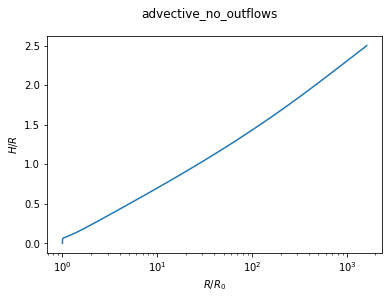

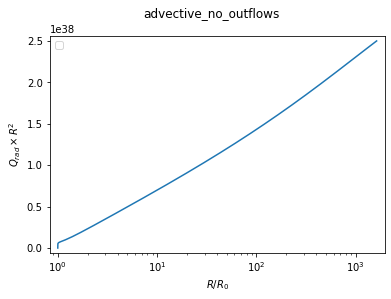

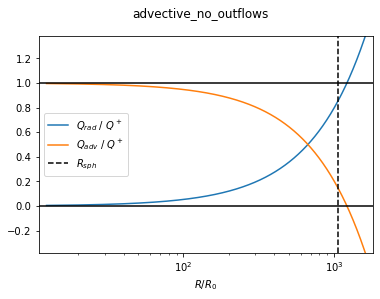

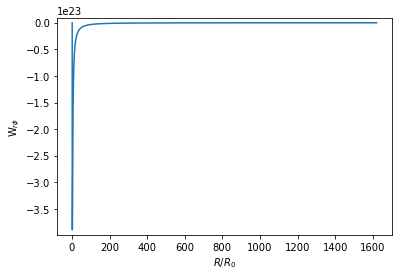

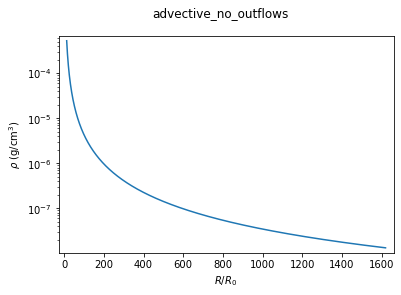

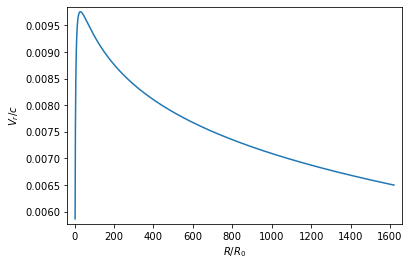

In [4]:
mdot = 1000
disk = AdvectiveDiskWithoutOutflows(M, mdot, alpha, Rmin=1, Rmax=300, spin=0, torque_Rmin=10**(-12))
disk.Rmax = 1.62 * disk.mdot
Mdot_0 = disk.Mdot_0
step = 0.1
solution = disk.solve(max_nodes=50000, step=step, verbose=1, H_boundary=10**(-15))
R = solution.x
height = solution.y[0]

Qrad = disk.Q_rad(height, R)
Rsph, L = find_rsph(Qrad, R, disk.M)

w = keplerian_angular_w(R, disk.M)

# H/R
fig = plt.figure()
fig.suptitle("%s" % disk.name)
r = R / disk.R0
plt.plot(r, height/ R)
plt.ylabel("$H/R$")
plt.xlabel("$R / R_0$")
plt.xscale("log")

# Qrad
fig = plt.figure()
fig.suptitle("%s" % disk.name)
plt.plot(r, Qrad * R**2)
plt.ylabel("$Q_{rad} \\times R^2$")
plt.margins(x=0.025, y=0.025)
plt.legend()
plt.xlabel("$R / R_0$")
plt.xscale("log")

Wrphi = disk.torque(R, w)
dWrphi = disk.torque_derivative(R, w)
rho = disk.density(Wrphi, height, w)
Mdot = disk.Mdot_0
dH = disk.Hprime(Mdot, height, R, Wrphi, dWrphi)
drho = disk.densityPrime(Wrphi, dWrphi, height, dH, Mdot, R)
Qadv = disk.Q_adv(Mdot, height, dH, rho, drho, R)
Q = -3/4 * w * Wrphi
# Q
fig = plt.figure()
fig.suptitle("%s" % disk.name)
margin = 300
print("Note that the zero-torque boundary condition creates a singularity at R_0 (Abramowicz+1988)")
plt.plot(r[margin:], (Qrad / Q)[margin:], label="$Q_{rad}$ / $Q^+$")
plt.plot(r[margin:], (Qadv / Q)[margin:], label="$Q_{adv}$ / $Q^+$")
plt.axhline(0, ls="solid", color="black")
plt.axhline(1, ls="solid", color="black")
plt.xlabel("$R / R_0$")
plt.axvline(Rsph / disk.R0, color="black", label="$R_{sph}$", ls="--")
plt.legend()
plt.margins(x = 0.025, y=0.0)
plt.legend()
plt.xscale("log")

# torque
plt.figure()
fig.suptitle("%s" % disk.name)
plt.plot(r, Wrphi)
plt.xlabel("$R / R_0$")
plt.ylabel("W$_{r\phi}$")
plt.margins(y=0.025)
# density
density = disk.density(Wrphi, height, w)
fig = plt.figure()
fig.suptitle("%s" % disk.name)
margin = 300
plt.plot(r[margin:], density[margin:]) # avoid the singularity at R_0
plt.yscale("log")
plt.margins(x=0.025, y=0.025)
plt.ylabel("$\\rho$ (g/cm$^3$)")
plt.xlabel("$R / R_0$")

# radial velocity
plt.figure()
fig.suptitle("%s" % disk.name)
v_r = disk.v_r(Mdot, height, density, R)
plt.plot(r[200:], v_r[200:]/c) # avoid the singularity at R_0
plt.margins(x=0.025, y=0.025)
plt.ylabel("$V_r / c$")
plt.xlabel("$R / R_0$")
print("Is energy conserved in %s disks?" % disk.name)
print(np.allclose(Qrad[margin:] + Qadv[margin:], Q[margin:])) # avoid the singularity at R_0

We can see that advection transports the energy inwards in the inner regions, while transports the generated radiation outwards beyond R ~ 100R_0. Thus the radii beyond 100R_0 radiate energy from the inner regions, thereby exceeding~ the energy generated in these radii. However, we can see that the total energy is conserved.

## Non-advective non-conservative disk

Disk with_outflows with M = 10.0 M_sun, dot(m) = 1000.0 and alpha = 0.1 and spin = 0.0
Solved in 2 iterations, number of nodes 16192. 
Maximum relative residual: 8.89e-04 
Maximum boundary residual: 0.00e+00
Is energy conserved in with_outflows disks?
True


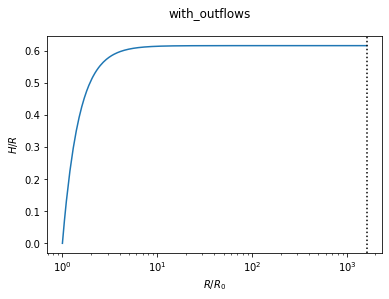

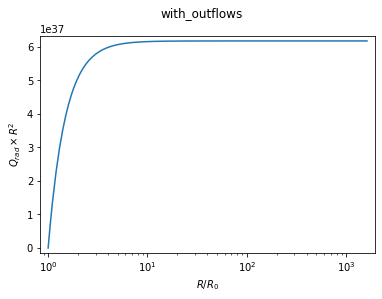

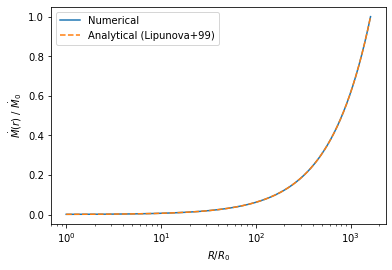

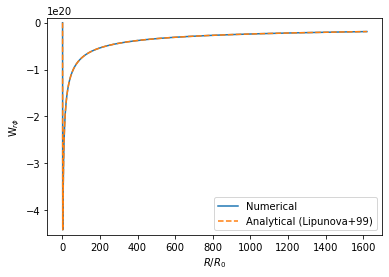

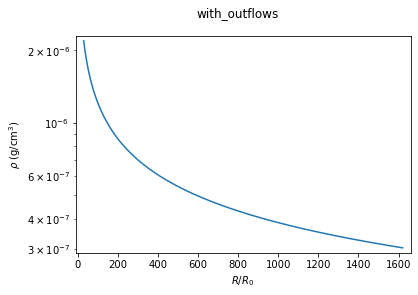

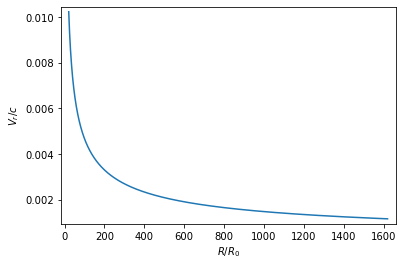

In [6]:
%matplotlib inline
mdot = 1000
disk = DiskWithOutflows(M, mdot, alpha, Rmin=1, spin=0)
disk.Rmax = disk.Rsph # set the maximum radius to the spherization radius where the outflow starts to develop
solution = disk.solve(step=0.1, max_nodes=2000000, verbose=1)
R = solution.x
r = R / disk.R0
w = keplerian_angular_w(R, disk.M)
Mdot = solution.y[0]
Wrphi = solution.y[1]
height = disk.H(Wrphi, w)
Qrad = disk.Q_rad(height, R)

# H /R
fig = plt.figure()
fig.suptitle("%s" % disk.name)
plt.plot(r, height/ R)
plt.axvline(1.62 * disk.mdot, color="black", label="1.62 $\dot{m}$", ls=":")
plt.ylabel("$H/R$")
plt.xlabel("$R / R_0$")
plt.xscale("log")
# Qrad
fig = plt.figure()
fig.suptitle("%s" % disk.name)
plt.plot(r, Qrad * R**2)
plt.ylabel("$Q_{rad} \\times R^2$")
plt.xscale("log")
plt.margins(x=0.025, y=0.025)
plt.xlabel("$R / R_0$")


# Mdot
plt.figure()
# Analytical result from Lipunova+99
Mdot_r = disk.Mdot_0 * (disk.Rsph/r)**(3 / 2) * (1 + 3/2 *(r)**(5/2)) / (1 + 3/2 * (disk.Rsph)**(5/2))
plt.plot(r, Mdot / disk.Mdot_0, label="Numerical")
plt.plot(r, Mdot_r / disk.Mdot_0, label="Analytical (Lipunova+99)", ls="--")
plt.legend()
plt.ylabel("$\dot{M}(r)$ / $\dot{M}_0$")
plt.xlabel("$R / R_0$")
plt.xscale("log")

# torque
plt.figure()
fig.suptitle("%s" % disk.name)
# Analytical solutions from Lipunova+99
Wrphi_lipunova = Mdot_r * w / (4 * np.pi) * (1 - (r)**(5/2)) / (1 + 3/2 * (r)**(5/2))
plt.plot(r, Wrphi, label="Numerical")
plt.plot(r, Wrphi_lipunova, label="Analytical (Lipunova+99)", ls="--")
plt.xlabel("$R / R_0$")
plt.ylabel("W$_{r\phi}$")
plt.margins(y=0.025)
plt.legend()
# density

density = disk.density(Wrphi, height, w)
fig = plt.figure()
fig.suptitle("%s" % disk.name)
margin = 300
plt.plot(r[margin:], density[margin:]) # avoid the singularity at R_0
plt.yscale("log")
plt.margins(x=0.025, y=0.025)
plt.ylabel("$\\rho$ (g/cm$^3$)")
plt.xlabel("$R / R_0$")

# radial velocity
plt.figure()
fig.suptitle("%s" % disk.name)
v_r = disk.v_r(Mdot, height, density, R)
plt.plot(r[200:], v_r[200:]/c) # avoid the singularity at R_0
plt.margins(x=0.025, y=0.025)
plt.ylabel("$V_r / c$")
plt.xlabel("$R / R_0$")
print("Is energy conserved in %s disks?" % disk.name)
Q = -3/4 * w * Wrphi
print(np.allclose(Qrad[margin:], Q[margin:])) # avoid the singularity at R_0

## Advective disk with outflows (non-conservative)

In [ ]:
mdot = 5
disk = AdvectiveDiskWithOutflows(M, mdot, alpha, Rmin=1, spin=0)
disk.Rmax = disk.Rsph # set the maximum radius to the spherization radius where the outflow starts to develop
solution = disk.solve(step=0.1, max_nodes=10000000, verbose=2) # reduce the step to reduce the computational burden
R = solution.x
height = solution.y[0]
Mdot = solution.y[1]
Wrphi = solution.y[2]
w = keplerian_angular_w(R, disk.M)

In [ ]:
w = keplerian_angular_w(R, disk.M)
# Assume the linear scaling from SS73 to start with
M_isco = mass_transfer_inner_radius(disk.mdot, disk.ewind) * disk.Mdot_0
Mdot_guess = M_isco + (disk.Mdot_0 - M_isco)  * (R / disk.R0) / disk.Rsph  # boundary condition, Mdot_0 at the Rsph
Wrphi_guess = disk.Mdot_0 * R / (disk.Rsph * disk.R0) * w / (4 * np.pi) * (1 - (R / disk.R0)**(5/2)) / (1 + 3/2 * (R / disk.R0)**(5/2))
Wrphi_guess[0] = 10**(-10)
H_guess = -3/4 * Wrphi_guess * k_T / (w * c)
plt.plot(r, H_guess/R)
plt.plot(r, Mdot_guess/disk.Mdot_0)
plt.figure()
plt.plot(r, Wrphi_guess)

In [ ]:

fig = plt.figure()
fig.suptitle("%s" % disk.name)
r = R / disk.R0
plt.plot(r, height/ R, label="$H/R$")
plt.plot(r, Mdot / disk.Mdot_0, label="$\dot{M} / \dot{M_0}$")
plt.xlabel("$R / R_0$")
plt.ylim(bottom=-0.1, top=5)
plt.legend()

Qrad = disk.Q_rad(height, R)
#Qrad[-1] = 0 # boundary condition
fig = plt.figure()
fig.suptitle("%s" % disk.name)
Q0 = keplerian_angular_w(disk.R0, disk.M) * disk.Mdot_0 / (8 * np.pi) # just a normalization factor
plt.plot(r, Qrad * r**2 / Q0, label="$Q_{rad} r^2 / Q_0$")
plt.ylim(bottom=0, top=10)
plt.xlabel("$R / R_0$")
plt.ylabel("$Q_{rad} \\times r^2 / Q_0$")


rho = disk.density(Wrphi, height, w)
dWrphi = disk.torque_derivative(Mdot, Wrphi, R, w)
dH = disk.Hprime_simplified(Mdot, height, R, Wrphi, dWrphi, w)
drho = disk.densityPrime(Wrphi, dWrphi, height, dH, Mdot, R)
Qadv = disk.Q_adv(Mdot, height, dH, rho, drho, R)
Q = -3/4 * w * Wrphi
fig = plt.figure()
fig.suptitle("%s" % disk.name)
margin = 200
plt.plot(r[margin:], (Qrad / Q)[margin:], label="$Q_{rad}$ / $Q^+$")
plt.plot(r[margin:], (Qadv / Q)[margin:], label="$Q_{adv}$ / $Q^+$")
plt.ylim(bottom=0, top=1.1)
plt.legend()
plt.xlabel("$R / R_0$")

plt.figure()
fig.suptitle("%s" % disk.name)
plt.plot(r, Wrphi)
plt.ylabel("W$_{r\phi}$")
plt.xlabel("$R / R_0$")